In [1]:
import ROOT as rt
import root_numpy as rtnp
import csv
import re
import sys
import uproot
import numpy as np
import awkward
import math
import numba

from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, std_color_list
from array import array
from prettytable import PrettyTable
import collections
from collections import OrderedDict
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

# donotdelete = []


Welcome to JupyROOT 6.16/00


In [2]:
# label['ggHm50ct100mmWISR'] = 'ggH M_{X} = 50 GeV, c#tau = 100 mm'

lumi = (37.80+44.98+63.67) * 1000 #in pb, CMS recorded 2016 + 2017 + 2018

onelep_br = 0.2134
twolep_br = 0.06729
    
wh = { 'mh125':1.475,
    'mh300':0.06724,
    'mh500':0.008621,
    'mh1000':3.585E-4,
    'mh2000':5.706E-06 }
zh = {  'mh125':9.095E-01,
    'mh300':4.132E-02,
    'mh500':5.256E-03,
    'mh1000':2.977E-04,
    'mh2000':7.639E-06 }
cs = {
}
masses = [ 'mh125', 'mh300','mh500','mh1000','mh2000']
pls = [ 'pl500','pl1000','pl10000']

modes = ['onelep','twolep']
for m in masses:
    cs[m] = {}
    cs[m]['onelep'] = wh[m]*onelep_br
    cs[m]['twolep'] = zh[m]*twolep_br

n_mc = {}
for k,v in cs.items():
    n_mc[k] = {}
    for j,u in v.items():
        n_mc[k][j] = lumi*u
        print(k,j,n_mc[k][j])


mh125 onelep 46097.33425
mh125 twolep 8962.77734475
mh300 onelep 2101.4133932
mh300 twolep 407.19291906
mh500 onelep 269.42719903
mh500 twolep 51.795885348000006
mh1000 onelep 11.203996155
mh1000 twolep 2.9337205228500003
mh2000 onelep 0.17832636558
mh2000 twolep 0.0752794459995


In [122]:
fpath =OrderedDict()
tree = OrderedDict()
NEvents = OrderedDict()
wzNEvents = OrderedDict()
trig = OrderedDict()
trig_lepId = OrderedDict()
trig_lepId_dijet = OrderedDict()

bbbb = 0
wH = 1

directory = '/mnt/hadoop/store/group/phys_exotica/delayedjets/llp_analyzer/V1p0/MC_Summer16/vH/'
if wH:
    file_name = 'wH_Tree.root'
else:
    file_name = 'zH_Tree.root'
if bbbb:
    fpath['mh125'] = directory + 'bbbb_withISR_mh125_mx50_pl1000_ev100000/'+file_name
    fpath['mh300'] = directory + 'bbbb_withISR_mh300_mx125_pl1000_ev100000/'+file_name
    fpath['mh500'] = directory + 'bbbb_withISR_mh500_mx225_pl1000_ev100000/'+file_name
    fpath['mh1000'] = directory + 'bbbb_withISR_mh1000_mx475_pl1000_ev100000/'+file_name
    fpath['mh2000'] = directory + 'bbbb_withISR_mh2000_mx975_pl1000_ev100000/'+file_name

else:
    fpath['mh125'] = directory + 'metbb_withISR_mh125_mx50_pl1000_ev100000/'+file_name
    fpath['mh300'] = directory + 'metbb_withISR_mh300_mx125_pl1000_ev100000/'+file_name
    fpath['mh500'] = directory + 'metbb_withISR_mh500_mx225_pl1000_ev100000/'+file_name
    fpath['mh1000'] = directory + 'metbb_withISR_mh1000_mx475_pl1000_ev100000/'+file_name
    fpath['mh2000'] = directory + 'metbb_withISR_mh2000_mx975_pl1000_ev100000/'+file_name

for k,v in fpath.items():
#         tree[k][j] = rtnp.root2array(u)
    root_dir = uproot.open(v) 
    wzNEvents[k] = root_dir['wzNEvents']
    trig[k] = root_dir['trig']
    trig_lepId[k] = root_dir['trig_lepId']
    trig_lepId_dijet[k] = root_dir['trig_lepId_dijet']

    tree[k] = root_dir['vH']
    a = tree[k]["jetPt"].array()
    print (a[:-1][0])
    
    
trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if wH:
    trigger_paths = [87,135] #PFMET120
else:
    trigger_paths = [177,362,87,135] #PFMET120

# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET




[29.614815 20.078245]
[61.15769 43.38087]
[154.40254   57.35065   24.428314]
[210.63249  154.34625  105.7752    41.322075  38.124897  26.134106]
[355.4672   131.57999   57.989983  26.670671]


In [3]:
# inclusive trigger efficiency * acceptance
triggered = {}

for k,T in tree_bkg.items():
    hlt = T['HLTDecision'].array()
    triggered[k] = np.zeros(hlt[:,0].shape)
#     print(len(hlt),wzNEvents[k][1],trig[k][1],trig_lepId[k][1],trig_lepId_dijet[k][1])
    for tr in trigger_paths:
        triggered[k]  = np.logical_or(triggered[k],hlt[:,tr])
    print(1.0*np.count_nonzero(triggered[k]),trig_lepId_dijet[k][1] )
    assert(np.count_nonzero(triggered[k]) == trig_lepId_dijet[k][1])

#     print(triggered[k].shape)

NameError: name 'tree_bkg' is not defined

In [124]:
met = {}
cuts = [15,30,50,100,300]
eff_table = PrettyTable()
fieldname = ["m#phi\met cut","triggered(%)","triggered+lepId(%)","triggered+lepid+dijet(%)"]
for c in cuts:
    fieldname.append(str(c)+' GeV(%)')
eff_table.field_names = fieldname
for k, T in tree.items():
    row = [k, round(trig[k][1]/wzNEvents[k][1]*100,2),round(trig_lepId[k][1]/wzNEvents[k][1]*100,2),round(trig_lepId_dijet[k][1]/wzNEvents[k][1]*100,2)]
    row_k = [round(trig[k][1]/wzNEvents[k][1]*100,2),round(trig_lepId[k][1]/wzNEvents[k][1]*100,2),round(trig_lepId_dijet[k][1]/wzNEvents[k][1]*100,2)]
    met[k] = T['met'].array()
#     print(k,', number of events:'+str((wzNEvents[k][1])))
    for i in cuts:
        triggered_met = np.logical_and(met[k]>i, triggered[k])
        eff = np.count_nonzero(triggered_met)/wzNEvents[k][1]
        row.append(str(round(eff*100,2)))
        row_k.append(round(eff*100,2))
    print(*row_k, sep=", ")
    eff_table.add_row(row)
print(eff_table)

46.96, 25.3, 5.74, 5.4, 4.54, 3.02, 0.43, 0.03
60.64, 32.73, 15.68, 15.37, 14.4, 12.38, 5.67, 0.11
64.04, 34.56, 22.9, 22.56, 21.56, 19.75, 12.48, 1.09
49.07, 26.23, 25.26, 25.1, 24.73, 23.79, 20.56, 5.61
49.37, 26.76, 26.38, 26.34, 26.22, 25.63, 23.1, 9.9
+---------------+--------------+--------------------+--------------------------+-----------+-----------+-----------+------------+------------+
| m#phi\met cut | triggered(%) | triggered+lepId(%) | triggered+lepid+dijet(%) | 15 GeV(%) | 30 GeV(%) | 50 GeV(%) | 100 GeV(%) | 300 GeV(%) |
+---------------+--------------+--------------------+--------------------------+-----------+-----------+-----------+------------+------------+
|     mh125     |    46.96     |        25.3        |           5.74           |    5.4    |    4.54   |    3.02   |    0.43    |    0.03    |
|     mh300     |    60.64     |       32.73        |          15.68           |   15.37   |    14.4   |   12.38   |    5.67    |    0.11    |
|     mh500     |    64.04  

In [125]:
## Cut on jet timing
jetTime = {}
jetTime_met = {}
met_cut = 30
time_cuts = [0, 0.25, 0.5,0.6,0.7,0.8,0.9,1]
time_cuts = [-3,-2,-1,0,0.5,1,2,3,4,5,6]
efftime_table = PrettyTable()
fieldname = ["m#phi\Time cut"]
for c in time_cuts:
    fieldname.append(str(c)+' ns')
efftime_table.field_names = fieldname
for k, T in tree.items():
    jetTime[k] = T['jetTime'].array()
    met[k] = T['met'].array()
#     print(k,', number of events:'+str(len(met[k])))
    triggered_met = np.logical_and(met[k] > met_cut, triggered[k])
    row = [k]
    row_keynote = []
    for i in time_cuts:
#         jetTime[k] = jetTime[k][np.logical_not(np.isnan(jetTime[k]))]
#         triggered_met = awkward.JaggedArray.fromiter([triggered_met[i] for i in range(len(triggered_met)) if len(jetTime[k][i])>0])
#         jetTime[k] = awkward.JaggedArray.fromiter([x for x in jetTime[k] if len(x)>0])
#         assert(jetTime[k].shape == triggered_met.shape)
#         triggered_time = np.logical_and(triggered_met, jetTime[k][:,0] > i)
        triggered_time = np.logical_and(triggered_met, (jetTime[k] > i).any())
        temp = jetTime[k] > i
        temp = temp.any()
#         print(temp[0],jetTime[k][0],i)
#         print(temp)
        jetTime_met[k] = jetTime[k][triggered_met][:,0]
        eff = np.count_nonzero(triggered_time)/wzNEvents[k][1]
        row.append(str(round(eff*100,2)))
        row_keynote.append(round(eff*100,2))
    efftime_table.add_row(row)
    print(*row_keynote, sep=", ")
print(efftime_table) # apply the time cut on max pT

3.8, 3.76, 3.58, 2.34, 1.48, 0.49, 0.09, 0.0, 0.0, 0.0, 0.0
12.96, 12.92, 12.76, 10.4, 7.23, 3.85, 1.51, 0.64, 0.2, 0.03, 0.02
19.96, 19.92, 19.77, 17.12, 12.91, 8.2, 4.25, 1.88, 0.77, 0.38, 0.2
24.47, 24.47, 24.42, 22.4, 18.1, 13.82, 8.63, 5.22, 3.07, 1.68, 0.58
26.15, 26.15, 26.15, 24.74, 21.27, 17.31, 12.8, 9.12, 5.75, 3.35, 2.04
+----------------+-------+-------+-------+-------+--------+-------+------+------+------+------+------+
| m#phi\Time cut | -3 ns | -2 ns | -1 ns |  0 ns | 0.5 ns |  1 ns | 2 ns | 3 ns | 4 ns | 5 ns | 6 ns |
+----------------+-------+-------+-------+-------+--------+-------+------+------+------+------+------+
|     mh125      |  3.8  |  3.76 |  3.58 |  2.34 |  1.48  |  0.49 | 0.09 | 0.0  | 0.0  | 0.0  | 0.0  |
|     mh300      | 12.96 | 12.92 | 12.76 |  10.4 |  7.23  |  3.85 | 1.51 | 0.64 | 0.2  | 0.03 | 0.02 |
|     mh500      | 19.96 | 19.92 | 19.77 | 17.12 | 12.91  |  8.2  | 4.25 | 1.88 | 0.77 | 0.38 | 0.2  |
|     mh1000     | 24.47 | 24.47 | 24.42 |  22.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


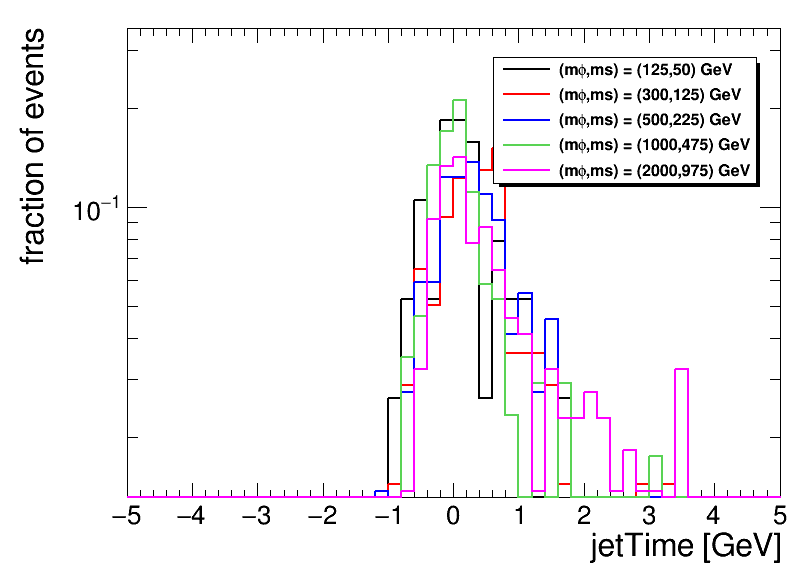

In [216]:
# plot leading jet pT
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.62,0.68,0.95,0.90);
leg.SetTextSize(0.03)
rt.gStyle.SetOptStat(0000)
i = 0

legend = {'mh125':'(m#phi,ms) = (125,50) GeV',
          'mh300':'(m#phi,ms) = (300,125) GeV',
         'mh500':'(m#phi,ms) = (500,225) GeV',
          'mh1000':'(m#phi,ms) = (1000,475) GeV',
          'mh2000':'(m#phi,ms) = (2000,975) GeV',
         }

for k,v in jetTime_met.items():   
#     h[k] = create_TH1D( v, axis_title=['MET [GeV]', 'fraction of events'], name=k, binning=[50,0,1500])
    h[k] = create_TH1D( v, axis_title=['jetTime [GeV]', 'fraction of events'], name=k, binning=[50,-5,5])
    h[k].SetLineColor(std_color_list[i])
    h[k].SetMarkerColor(std_color_list[i])

    leg.AddEntry(h[k],legend[k])
#     h[k].GetYaxis().SetRangeUser(0,300)
    if i == 0:
        h[k].DrawNormalized('')
    else:
        h[k].DrawNormalized('same')
    i += 1
leg.Draw()
c.SetLogy()
c.Draw()